# Sales Prediction for Time Series Data

## Part 4: Models (Light GBM)

In [1]:
import numpy as np
import pandas as pd 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import lightgbm as lgb
import os
import time 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc

%matplotlib inline 

In [2]:
def submission(model, X_test):
    '''
    make submission file
    arguments:    model = model name 
                  X_test= X_test name
    return: a file saved in directory with timestamp
    '''
    # model prediction
    pred = model.predict(X_test)
    print('mean before clipping: ', pred.mean())
    pred = pred.clip(0,20)
    print('mean after clipping: ', pred.mean())

    # create prediction dataframe
    ID = joblib.load('ID.pkl')
    predDF = pd.DataFrame() 
    predDF['ID'] = ID
    predDF['item_cnt_month'] = pred
    print(predDF.head())

    # write dataframe to csv
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%m%d_%H.%M')
    print('submission_' + st + '.csv')
    
    predDF.to_csv(header=True, index=False, path_or_buf = 'submission_' + st + '.csv')
    
    return None

### Light GBM

In [3]:
X_train = pd.read_pickle('../data/X_train_lev_1_RobustScalerTree')
y_train = joblib.load('../data/y_train_lev_1.pkl')
X_test = pd.read_pickle('../data/X_test_lev_1_RobustScalerTree')
y_test = joblib.load('../data/y_val_lev_1.pkl')
X_test_full = pd.read_pickle('../data/X_test_RobustScalerTree')
X_train_full = pd.read_pickle('../data/X_train_RobustScalerTree')
y_train_full = joblib.load('../data/y_train_full.pkl')

In [4]:
X_train = X_train.drop(list(X_train.filter(like= 'shop_id_').columns), axis = 1)
X_test = X_test.drop(list(X_test.filter(like='shop_id_').columns), axis = 1)

In [5]:
train_data = lgb.Dataset(X_train, label= y_train)
test_data = lgb.Dataset(X_test, label = y_test)

In [6]:
def lgb_model(params):
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], verbose_eval=25)
    return lgb_model

Set parameters

In [7]:
params = {
    'application':'regression',
    'learning_rate':0.03,
    'early_stopping_round':50,
    'metric':'l2_root', #RMSE
    'nthread':-1, 
    'train_metric': True,
    'num_boost_round': 500
}

#### Baseline for 'boosting' = gbdt

In [8]:
model = lgb_model(params) 

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.980943	valid_1's rmse: 1.19688
[50]	training's rmse: 0.875039	valid_1's rmse: 1.11219
[75]	training's rmse: 0.83398	valid_1's rmse: 1.08451
[100]	training's rmse: 0.812704	valid_1's rmse: 1.07357
[125]	training's rmse: 0.797748	valid_1's rmse: 1.06766
[150]	training's rmse: 0.786947	valid_1's rmse: 1.06286
[175]	training's rmse: 0.778849	valid_1's rmse: 1.06076
[200]	training's rmse: 0.772308	valid_1's rmse: 1.05767
[225]	training's rmse: 0.765993	valid_1's rmse: 1.0539
[250]	training's rmse: 0.760576	valid_1's rmse: 1.05256
[275]	training's rmse: 0.755969	valid_1's rmse: 1.04999
[300]	training's rmse: 0.751383	valid_1's rmse: 1.04821
[325]	training's rmse: 0.747336	valid_1's rmse: 1.04665
[350]	training's rmse: 0.743704	valid_1's rmse: 1.04652
[375]	training's rmse: 0.740628	valid_1's rmse: 1.04632
[400]	training's rmse: 0.736992	valid_1's rmse: 1.04496
[425]	training's rmse: 0.734182	valid_1's rmse:

#### Baseline for 'boosting' = dart

In [9]:
params_1 = params.copy()
params_1['boosting']='dart'

In [10]:
model = lgb_model(params_1)

[25]	training's rmse: 1.01242	valid_1's rmse: 1.2222
[50]	training's rmse: 0.95669	valid_1's rmse: 1.17809
[75]	training's rmse: 0.926141	valid_1's rmse: 1.15783
[100]	training's rmse: 0.920248	valid_1's rmse: 1.15539


#### Manual Tuning
Try to speed up training by changing feature_fraction from 1, bagging_freq from 0, and bagging_fraction from 1.  
<br>Result: Changing these parameters did not speed up training.  

In [11]:
params_2 = params.copy()
params_2['boosting']='dart'
params_2['feature_fraction'] = 0.75
params_2['bagging_freq'] = 1
params_2['bagging_fraction'] = 0.75

In [12]:
model = lgb_model(params_2)

[25]	training's rmse: 1.0187	valid_1's rmse: 1.23118
[50]	training's rmse: 0.95925	valid_1's rmse: 1.18556
[75]	training's rmse: 0.926286	valid_1's rmse: 1.16141
[100]	training's rmse: 0.920836	valid_1's rmse: 1.15533


Try to speed up by increasing bagging_freq from 1 to 10.  
Result: this did speed up training.  

In [13]:
params_3 = params.copy()
params_3['boosting']='dart'
params_3['feature_fraction'] = 0.75
params_3['bagging_freq'] = 10
params_3['bagging_fraction'] = 0.75

In [14]:
model = lgb_model(params_3)

[25]	training's rmse: 1.01776	valid_1's rmse: 1.23386
[50]	training's rmse: 0.959701	valid_1's rmse: 1.18816
[75]	training's rmse: 0.926533	valid_1's rmse: 1.15987
[100]	training's rmse: 0.921105	valid_1's rmse: 1.1565


See what happens by chaing bagging_freq back from 10 to 1.  
Result: this slows down training.

In [15]:
params_4 = params.copy()
params_4['boosting']='dart'
params_4['num_boost_round'] = 500
params_4['learning_rate'] = 0.03
params_4['feature_fraction'] = 0.75
params_4['bagging_freq'] = 1
params_4['bagging_fraction'] = 0.75

In [16]:
model = lgb_model(params_4)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	training's rmse: 1.0187	valid_1's rmse: 1.23118
[50]	training's rmse: 0.95925	valid_1's rmse: 1.18556
[75]	training's rmse: 0.926286	valid_1's rmse: 1.16141
[100]	training's rmse: 0.920836	valid_1's rmse: 1.15533
[125]	training's rmse: 0.909683	valid_1's rmse: 1.14806
[150]	training's rmse: 0.896396	valid_1's rmse: 1.13868
[175]	training's rmse: 0.87297	valid_1's rmse: 1.12152
[200]	training's rmse: 0.861237	valid_1's rmse: 1.11302
[225]	training's rmse: 0.854846	valid_1's rmse: 1.11027
[250]	training's rmse: 0.84068	valid_1's rmse: 1.09945
[275]	training's rmse: 0.828759	valid_1's rmse: 1.09074
[300]	training's rmse: 0.824597	valid_1's rmse: 1.08849
[325]	training's rmse: 0.820749	valid_1's rmse: 1.08727
[350]	training's rmse: 0.818404	valid_1's rmse: 1.08612
[375]	training's rmse: 0.811143	valid_1's rmse: 1.0813
[400]	training's rmse: 0.80295	valid_1's rmse: 1.07661
[425]	training's rmse: 0.799133	valid_1's rmse: 1.07534
[450]	training's rmse: 0.797666	valid_1's rmse: 1.07603
[4

See if RMSE will improve by increasing num_leaves (number of leaves in one tree) from default of 31 to 128.  
<br> Result: best iteration decreased

In [17]:
params_5 = params.copy()
params_5['boosting']='dart'
params_5['feature_fraction'] = 0.75
params_5['bagging_freq'] = 1
params_5['bagging_fraction'] = 0.75
params_5['num_leaves']= 2**7

In [18]:
model = lgb_model(params_5)

[25]	training's rmse: 0.980544	valid_1's rmse: 1.22589
[50]	training's rmse: 0.913573	valid_1's rmse: 1.18284
[75]	training's rmse: 0.875333	valid_1's rmse: 1.15896
[100]	training's rmse: 0.868977	valid_1's rmse: 1.15664


Increase num_leaves again from 128 to 256.
<br> Result: similar result for both 128 and 256 num_leaves.  The difference between training and validation RMSE tightened slightly

In [19]:
params_6 = params.copy()
params_6['boosting']='dart'
params_6['feature_fraction'] = 0.75
params_6['bagging_freq'] = 1
params_6['bagging_fraction'] = 0.75
params_6['num_leaves']= 2**8

In [20]:
model = lgb_model(params_6)

[25]	training's rmse: 0.963346	valid_1's rmse: 1.22157
[50]	training's rmse: 0.891259	valid_1's rmse: 1.17839
[75]	training's rmse: 0.850221	valid_1's rmse: 1.1556
[100]	training's rmse: 0.843187	valid_1's rmse: 1.15118


See if over-fitting can be reduced by increasing 'min_data_in_leaf' from 20 to 128.
<br> Result: model seem to be more genralized and validation RMSE improved.

In [21]:
params_7 = params.copy()
params_7['boosting']='dart'
params_7['feature_fraction'] = 0.75
params_7['bagging_freq'] = 1
params_7['bagging_fraction'] = 0.75
params_7['num_leaves']= 2**8
params_7['min_data_in_leaf']= 2**7

In [22]:
model = lgb_model(params_7)

[25]	training's rmse: 0.987151	valid_1's rmse: 1.21026
[50]	training's rmse: 0.922536	valid_1's rmse: 1.15323
[75]	training's rmse: 0.886212	valid_1's rmse: 1.12868
[100]	training's rmse: 0.879549	valid_1's rmse: 1.12441


Try if increasing drop rate from 0.1 to 0.3 will further improve the model.  
<br> Result: The drop rate seem to add regularization

In [23]:
params_8 = params.copy()
params_8['boosting']='dart'
params_8['num_boost_round'] = 500
params_8['learning_rate'] = 0.03
params_8['feature_fraction'] = 0.75
params_8['bagging_freq'] = 1
params_8['bagging_fraction'] = 0.75
params_8['num_leaves']= 2**8
params_8['min_data_in_leaf']= 2**7
params_8['drop_rate']= 0.3

In [24]:
model = lgb_model(params_8)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	training's rmse: 1.02223	valid_1's rmse: 1.24113
[50]	training's rmse: 0.973733	valid_1's rmse: 1.19622
[75]	training's rmse: 0.924533	valid_1's rmse: 1.15839
[100]	training's rmse: 0.921811	valid_1's rmse: 1.16026
[125]	training's rmse: 0.903863	valid_1's rmse: 1.14833
[150]	training's rmse: 0.882261	valid_1's rmse: 1.13346
[175]	training's rmse: 0.847542	valid_1's rmse: 1.10597
[200]	training's rmse: 0.831284	valid_1's rmse: 1.09733
[225]	training's rmse: 0.821889	valid_1's rmse: 1.09117
[250]	training's rmse: 0.80136	valid_1's rmse: 1.07869
[275]	training's rmse: 0.783514	valid_1's rmse: 1.06276
[300]	training's rmse: 0.778179	valid_1's rmse: 1.06094
[325]	training's rmse: 0.772059	valid_1's rmse: 1.05769
[350]	training's rmse: 0.768184	valid_1's rmse: 1.05473
[375]	training's rmse: 0.758095	valid_1's rmse: 1.04642
[400]	training's rmse: 0.746261	valid_1's rmse: 1.04259
[425]	training's rmse: 0.739984	valid_1's rmse: 1.04289
[450]	training's rmse: 0.737404	valid_1's rmse: 1.042

Try increasing min_data_in_leaf from 128 to 256.  

In [25]:
params_9 = params.copy()
params_9['boosting']='dart'
params_9['num_boost_round'] = 500
params_9['learning_rate'] = 0.03
params_9['feature_fraction'] = 0.75
params_9['bagging_freq'] = 1
params_9['bagging_fraction'] = 0.75
params_9['num_leaves']= 2**8
params_9['min_data_in_leaf']= 2**8

In [26]:
model = lgb_model(params_9)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	training's rmse: 1.00182	valid_1's rmse: 1.20955
[50]	training's rmse: 0.941806	valid_1's rmse: 1.15929
[75]	training's rmse: 0.907667	valid_1's rmse: 1.13128
[100]	training's rmse: 0.901282	valid_1's rmse: 1.12706
[125]	training's rmse: 0.889253	valid_1's rmse: 1.11815
[150]	training's rmse: 0.874382	valid_1's rmse: 1.1117
[175]	training's rmse: 0.849727	valid_1's rmse: 1.09274
[200]	training's rmse: 0.836727	valid_1's rmse: 1.08632
[225]	training's rmse: 0.830303	valid_1's rmse: 1.08293
[250]	training's rmse: 0.814971	valid_1's rmse: 1.07468
[275]	training's rmse: 0.801412	valid_1's rmse: 1.06574
[300]	training's rmse: 0.79725	valid_1's rmse: 1.06397
[325]	training's rmse: 0.792566	valid_1's rmse: 1.06284
[350]	training's rmse: 0.789839	valid_1's rmse: 1.06087
[375]	training's rmse: 0.781728	valid_1's rmse: 1.05501
[400]	training's rmse: 0.772329	valid_1's rmse: 1.05229
[425]	training's rmse: 0.766986	valid_1's rmse: 1.0504
[450]	training's rmse: 0.764833	valid_1's rmse: 1.05131

How would the gbdt model perform with the same parameters?
<br> Result: performance is comparable to model with drop-out.

In [8]:
params_10 = params.copy()
params_10['boosting']='gbdt'
params_10['num_boost_round'] = 1000
params_10['learning_rate'] = 0.03
params_10['feature_fraction'] = 0.75
params_10['bagging_freq'] = 1
params_10['bagging_fraction'] = 0.75
params_10['num_leaves']= 2**8
params_10['min_data_in_leaf']= 2**8

In [9]:
model = lgb_model(params_10)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.968221	valid_1's rmse: 1.1803
[50]	training's rmse: 0.853591	valid_1's rmse: 1.08527
[75]	training's rmse: 0.808801	valid_1's rmse: 1.05265
[100]	training's rmse: 0.785914	valid_1's rmse: 1.04236
[125]	training's rmse: 0.769319	valid_1's rmse: 1.03668
[150]	training's rmse: 0.757082	valid_1's rmse: 1.03422
[175]	training's rmse: 0.746829	valid_1's rmse: 1.03196
[200]	training's rmse: 0.739181	valid_1's rmse: 1.03157
[225]	training's rmse: 0.732359	valid_1's rmse: 1.03138
[250]	training's rmse: 0.726931	valid_1's rmse: 1.03171
Early stopping, best iteration is:
[217]	training's rmse: 0.734246	valid_1's rmse: 1.03119


Save the model

In [10]:
print(model.best_iteration)

217


In [11]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%m%d_%H.%M')
model.save_model('lgb_model_' + st + '.txt', num_iteration= model.best_iteration)
lgb_model = model

In [12]:
print('lgb_model_' + st + '.txt')

lgb_model_0131_17.30.txt


In [ ]:
# To load the model
# lgb_model = lgb.Booster(model_file="lgb_model.txt") 

#### Feature Importance

In [31]:
importance = lgb_model.feature_importance()
names = lgb_model.feature_name()
varImpDf = pd.DataFrame(importance, index= names)

varImpDf.reset_index(inplace=True)
varImpDf = varImpDf.sort_values([0], ascending = False).reset_index(drop = True)
varImpDf= varImpDf.rename(columns={'index':'feature', 0:"importance"})

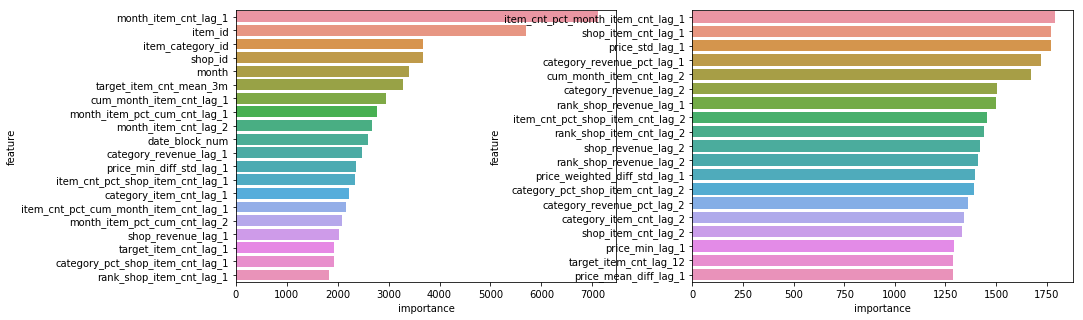

In [32]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.subplot(1, 2, 1)
sns.barplot(x="importance", y="feature", data=varImpDf.iloc[0:20,])
plt.subplot(1, 2, 2)
sns.barplot(x="importance", y="feature", data=varImpDf.iloc[21:40,])

#### Full Set light GBM
<br>The RMSE for this submission: 0.92476

In [14]:
y_train_full = joblib.load('../data/y_train_full.pkl')

In [15]:
train_data = lgb.Dataset(X_train_full, label= y_train_full)

In [16]:
params_11 = params.copy()
params_11['boosting']='gbdt'
params_11['learning_rate'] = 0.03
params_11['feature_fraction'] = 0.75
params_11['bagging_freq'] = 1
params_11['bagging_fraction'] = 0.75
params_11['num_leaves']= 2**8
params_11['min_data_in_leaf']= 2**7
params_11['num_boost_round']= 100 #100 and 200 round returned the score of 0.94423

In [17]:
model = lgb.train(params_11, train_data, valid_sets=[train_data], verbose_eval=25)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\lightgbm\engine.py:103: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.925598
[50]	training's rmse: 0.836038
[75]	training's rmse: 0.79967
[100]	training's rmse: 0.780338


In [20]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%m%d_%H.%M')
model.save_model('lgb_model_full_' + st + '.txt')
print('lgb_model_full_' + st + '.txt')

lgb_model_full_0131_17.52.txt


In [21]:
submission(model, X_test_full)

mean before clipping:  0.28181718124722316
mean after clipping:  0.28183406221699625
   ID  item_cnt_month
0   0        0.515650
1   1        0.464454
2   2        0.726331
3   3        0.408764
4   4        1.583937
submission_0131_17.52.csv


This is for referencing the default parameters

In [ ]:
'''
all_parameters = {'application': 'regression',
 'bagging_fraction': [1.0],
 'bagging_freq': [0],
 'bagging_seed': [3],
 'boosting': ['gbdt'],
 'drop_rate': [0.1],
 'drop_seed': [4],
 'feature_fraction': [1.0],
 'feature_fraction_seed': [3],
 'is_training_metric': [True],
 'lambda_l1': [0],
 'lambda_l2': [0],
 'learning_rate': [0.1],
 'max_bin': 255,
 'max_depth': [-1],
 'max_drop': [50],
 'metric': ['l2_root'],
 'metric_freq': [10],
 'min_data_in_leaf': [20],
 'min_gain_to_split': [0],
 'min_sum_hessian_in_leaf': [0.001],
 'num_leaves': [31],
 'skip_drop': [0.5],
 'uniform_drop': [False],
 'verbose': 1,
 'xgboost_dart_mode': [False]}
 '''